In [1]:
import os
os.environ["PATH"] += os.pathsep + "C:\Program Files (x86)\Graphviz\bin"

import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family = "Malgun Gothic")
matplotlib.rcParams['axes.unicode_minus'] = False
%matplotlib inline

from scipy import stats
from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings('ignore')

# 데이터 불러오기

In [2]:
df = pd.read_csv('구매결정모형비중data.csv')

In [3]:
df = df.drop(['회원번호'],axis=1)
df = df.drop(['홈페이지가입후경과일'],axis=1)

In [4]:
df.columns

Index(['재구매유무', '클래식비중', '실내악비중', '연극비중', '오페라비중', '교향곡비중', '뮤지컬비중', '독주비중',
       '성악비중', '기타비중', '발레비중', '무용비중', '합창비중', '콘서트비중', '재즈비중', '가족극비중',
       '아동극비중', 'SAC비중', '전시비중', '복합장르비중', '크로스오버비중', '체험비중', '대관공연비중',
       '회당평균구매티켓수', '유료회원유무', '성별', '아카데미수강유무', '마지막티켓구매후경과일', '나이'],
      dtype='object')

In [5]:
x_features = df.drop(['재구매유무'],axis=1)
y_labels = df['재구매유무']

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_labels, test_size=0.3, random_state = 156)
print(x_train.shape, x_test.shape)

(51942, 28) (22262, 28)


In [7]:
print(y_train.value_counts() / y_train.shape[0]*100)

0    62.552462
1    37.447538
Name: 재구매유무, dtype: float64


In [8]:
# Confusion Matrix
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))

In [9]:
# Precision Recall Curve
def precision_recall_curve_plot(y_test, pred_proba_c1):
    #threshold ndarray threshold 정밀도 재현율 
    precisions,recalls,thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    #x축은 threshold값으로 y축은 정밀도, 재현율 값으로 각각 plot 수행, 정밀도는 점선으로
    plt.figure(figsize = (8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds,precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds,recalls[0:threshold_boundary], label = 'recall')
    
    #threshold값 x축 scale 0.1단위로
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1), 2))
    
    plt.xlabel("threshold value")
    plt.ylabel('precision and recall value')
    plt.legend()
    plt.grid()
    plt.show()

# 분석 모델 선정

## Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier

In [11]:
dt = DecisionTreeClassifier(random_state=0)
dt.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

### Confusion Matrix

In [12]:
pred = dt.predict(x_test)
prob = dt.predict_proba(x_test)[:,1]
get_clf_eval(y_test, pred, prob)

오차행렬
[[13226   784]
 [  734  7518]]
정확도: 0.9318, 정밀도: 0.9056, 재현율: 0.9111, F1: 0.9083, AUC:0.9275


In [13]:
y_prob = dt.predict_proba(x_test)
y_prob2 = y_prob[:,1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, prob)

# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' 
      % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (dt.predict_proba(x_test)[:,1] >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, 
                            target_names = ['normal', 'abnormal']))

Best Threshold=1.000000, sensitivity = 0.911, specificity = 0.944, J=0.855
              precision    recall  f1-score   support

      normal       0.95      0.94      0.95     14010
    abnormal       0.91      0.91      0.91      8252

    accuracy                           0.93     22262
   macro avg       0.93      0.93      0.93     22262
weighted avg       0.93      0.93      0.93     22262



### ROC Curve

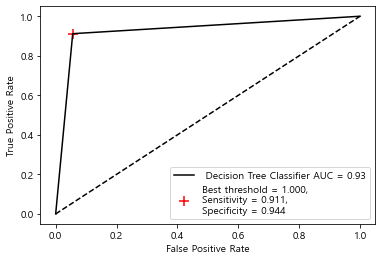

In [14]:
#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle = '--', markersize = 0.01, color = 'black')
plt.plot(fpr, tpr, marker = '.', color = 'black', markersize = 0.05, label = " Decision Tree Classifier AUC = %.2f" 
         % roc_auc_score(y_test, y_prob2))
plt.scatter(fpr[ix], tpr[ix], marker = '+', s=100, color = 'r', 
            label='Best threshold = %.3f, \nSensitivity = %.3f, \nSpecificity = %.3f' % (best_thresh, sens, spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 4)

# show the plot
plt.show()

### Precision, Recall Curve

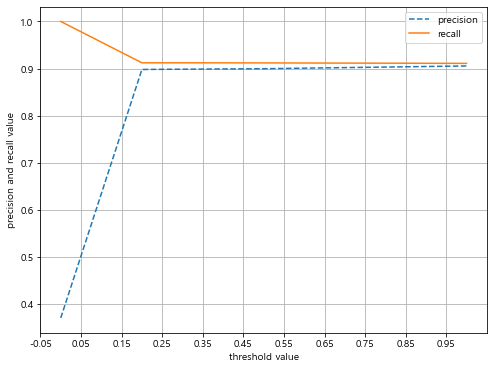

In [15]:
precision_recall_curve_plot(y_test, dt.predict_proba(x_test)[:,1])

In [16]:
print("DT train accuracy: %0.3f" % dt.score(x_train, y_train))
print("DT test accuracy: %0.3f" % dt.score(x_test, y_test))

DT train accuracy: 0.998
DT test accuracy: 0.932


### Permutaion Importance

In [17]:
import eli5
from eli5.sklearn import PermutationImportance

In [18]:
perm = PermutationImportance(dt,random_state = 0).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

Weight,Feature
0.1139 ± 0.0042,교향곡비중
0.1070 ± 0.0011,대관공연비중
0.0855 ± 0.0038,마지막티켓구매후경과일
0.0567 ± 0.0028,회당평균구매티켓수
0.0483 ± 0.0020,클래식비중
0.0394 ± 0.0025,무용비중
0.0151 ± 0.0009,뮤지컬비중
0.0138 ± 0.0017,독주비중
0.0097 ± 0.0010,오페라비중
0.0082 ± 0.0012,실내악비중


### Feature Importance

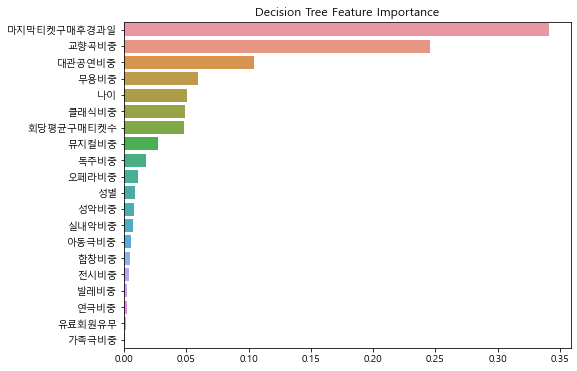

In [19]:
ftr_importances_values = dt.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (8,6))
plt.title("Decision Tree Feature Importance")
sns.barplot(x = ftr_top20,y = ftr_top20.index)
plt.show()

## Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

### Confusion Matrix

In [22]:
pred = rf.predict(x_test)
prob = rf.predict_proba(x_test)[:,1]
get_clf_eval(y_test, pred, prob)

오차행렬
[[13803   207]
 [  776  7476]]
정확도: 0.9558, 정밀도: 0.9731, 재현율: 0.9060, F1: 0.9383, AUC:0.9456


In [23]:
y_prob = rf.predict_proba(x_test)
y_prob2 = y_prob[:,1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, prob)

# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' 
      % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (rf.predict_proba(x_test)[:,1] >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

Best Threshold=0.595000, sensitivity = 0.901, specificity = 0.992, J=0.893
              precision    recall  f1-score   support

      normal       0.94      0.99      0.97     14010
    abnormal       0.98      0.90      0.94      8252

    accuracy                           0.96     22262
   macro avg       0.96      0.95      0.95     22262
weighted avg       0.96      0.96      0.96     22262



### ROC Curve

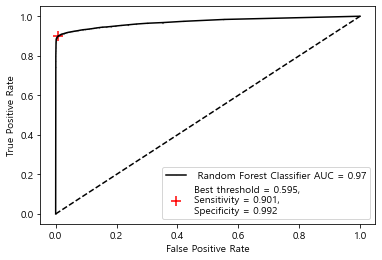

In [24]:
#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle = '--', markersize = 0.01, color = 'black')
plt.plot(fpr, tpr, marker = '.', color = 'black', markersize = 0.05, label = " Random Forest Classifier AUC = %.2f" 
         % roc_auc_score(y_test, y_prob2))
plt.scatter(fpr[ix], tpr[ix], marker = '+', s = 100, color = 'r', 
            label='Best threshold = %.3f, \nSensitivity = %.3f, \nSpecificity = %.3f' 
            % (best_thresh, sens, spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 4)

# show the plot
plt.show()

### Precision, Recall Curve

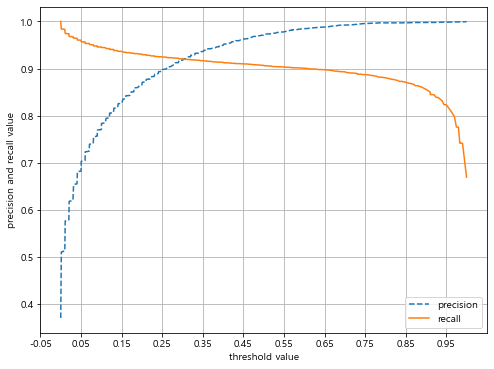

In [25]:
precision_recall_curve_plot(y_test,rf.predict_proba(x_test)[:,1])

In [26]:
print("RF train accuracy: %0.3f" % rf.score(x_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(x_test, y_test))

RF train accuracy: 0.998
RF test accuracy: 0.956


In [27]:
perm = PermutationImportance(rf,random_state = 0).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

Weight,Feature
0.1116 ± 0.0036,교향곡비중
0.1044 ± 0.0016,대관공연비중
0.0847 ± 0.0046,마지막티켓구매후경과일
0.0650 ± 0.0019,클래식비중
0.0538 ± 0.0026,회당평균구매티켓수
0.0384 ± 0.0013,실내악비중
0.0327 ± 0.0020,무용비중
0.0238 ± 0.0016,독주비중
0.0191 ± 0.0011,오페라비중
0.0103 ± 0.0011,뮤지컬비중


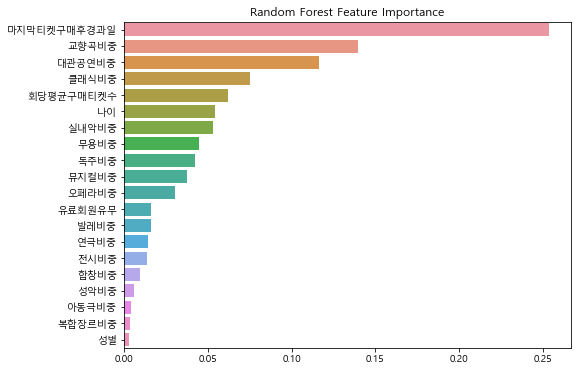

In [28]:
ftr_importances_values = rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (8,6))
plt.title("Random Forest Feature Importance")
sns.barplot(x = ftr_top20,y = ftr_top20.index)
plt.show()

## XGBoost

In [29]:
from xgboost import XGBClassifier
from xgboost import plot_importance

In [30]:
xgb = XGBClassifier(random_state = 0)
xgb.fit(x_train, y_train)

[17:01:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Confusion Matrix

In [31]:
pred = xgb.predict(x_test)
prob = xgb.predict_proba(x_test)[:,1]
get_clf_eval(y_test, pred, prob)

오차행렬
[[13983    27]
 [  747  7505]]
정확도: 0.9652, 정밀도: 0.9964, 재현율: 0.9095, F1: 0.9510, AUC:0.9538


In [32]:
y_prob = xgb.predict_proba(x_test)
y_prob2 = y_prob[:,1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, prob)

# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' 
      % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (xgb.predict_proba(x_test)[:,1] >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

Best Threshold=0.429363, sensitivity = 0.912, specificity = 0.997, J=0.908
              precision    recall  f1-score   support

      normal       0.95      1.00      0.97     14010
    abnormal       0.99      0.91      0.95      8252

    accuracy                           0.97     22262
   macro avg       0.97      0.95      0.96     22262
weighted avg       0.97      0.97      0.96     22262



### ROC Curve

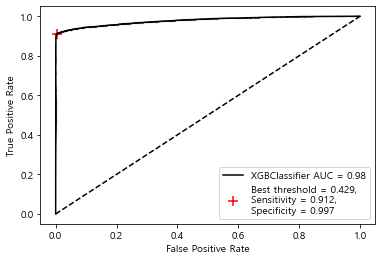

In [33]:
#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle = '--', markersize = 0.01, color = 'black')
plt.plot(fpr, tpr, marker = '.', color = 'black', markersize = 0.05, label = "XGBClassifier AUC = %.2f" 
         % roc_auc_score(y_test, y_prob2))
plt.scatter(fpr[ix], tpr[ix], marker = '+', s = 100, color = 'r', 
            label = 'Best threshold = %.3f, \nSensitivity = %.3f, \nSpecificity = %.3f' 
            % (best_thresh, sens, spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 4)

# show the plot
plt.show()

### Precision, Recall Curve

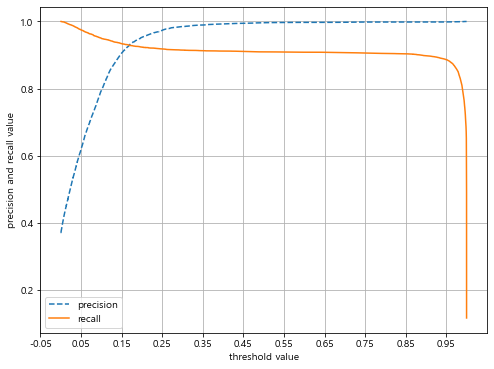

In [34]:
precision_recall_curve_plot(y_test,xgb.predict_proba(x_test)[:,1])

In [35]:
print("XGB train accuracy: %0.3f" % xgb.score(x_train, y_train))
print("XGB test accuracy: %0.3f" % xgb.score(x_test, y_test))

XGB train accuracy: 0.966
XGB test accuracy: 0.965


### Permutaion Importance

In [36]:
perm = PermutationImportance(xgb, random_state = 0).fit(x_test, y_test)
eli5.show_weights(perm,feature_names = x_test.columns.tolist())

Weight,Feature
0.1130 ± 0.0021,회당평균구매티켓수
0.0996 ± 0.0030,대관공연비중
0.0946 ± 0.0046,교향곡비중
0.0814 ± 0.0038,마지막티켓구매후경과일
0.0385 ± 0.0020,클래식비중
0.0377 ± 0.0023,실내악비중
0.0220 ± 0.0013,뮤지컬비중
0.0208 ± 0.0019,무용비중
0.0189 ± 0.0014,발레비중
0.0158 ± 0.0018,오페라비중


### Feature Importance

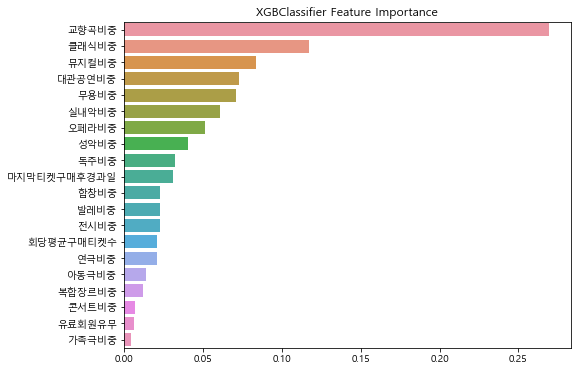

In [38]:
ftr_importances_values = xgb.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (8,6))
plt.title("XGBClassifier Feature Importance")
sns.barplot(x = ftr_top20, y = ftr_top20.index)
plt.show()

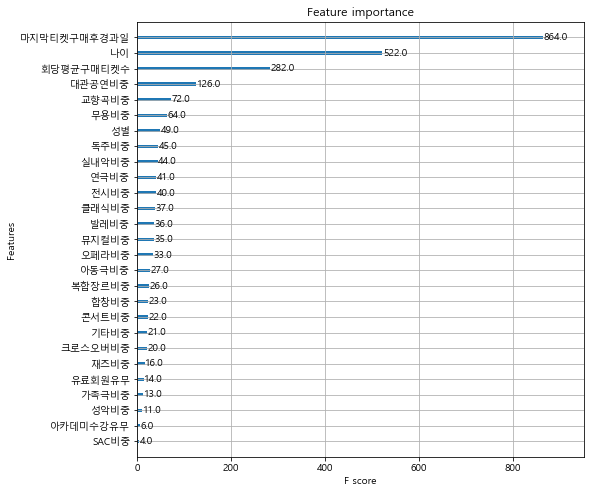

In [37]:
fig, ax = plt.subplots(figsize = (8,8))
plot_importance(xgb, ax = ax)
plt.show()

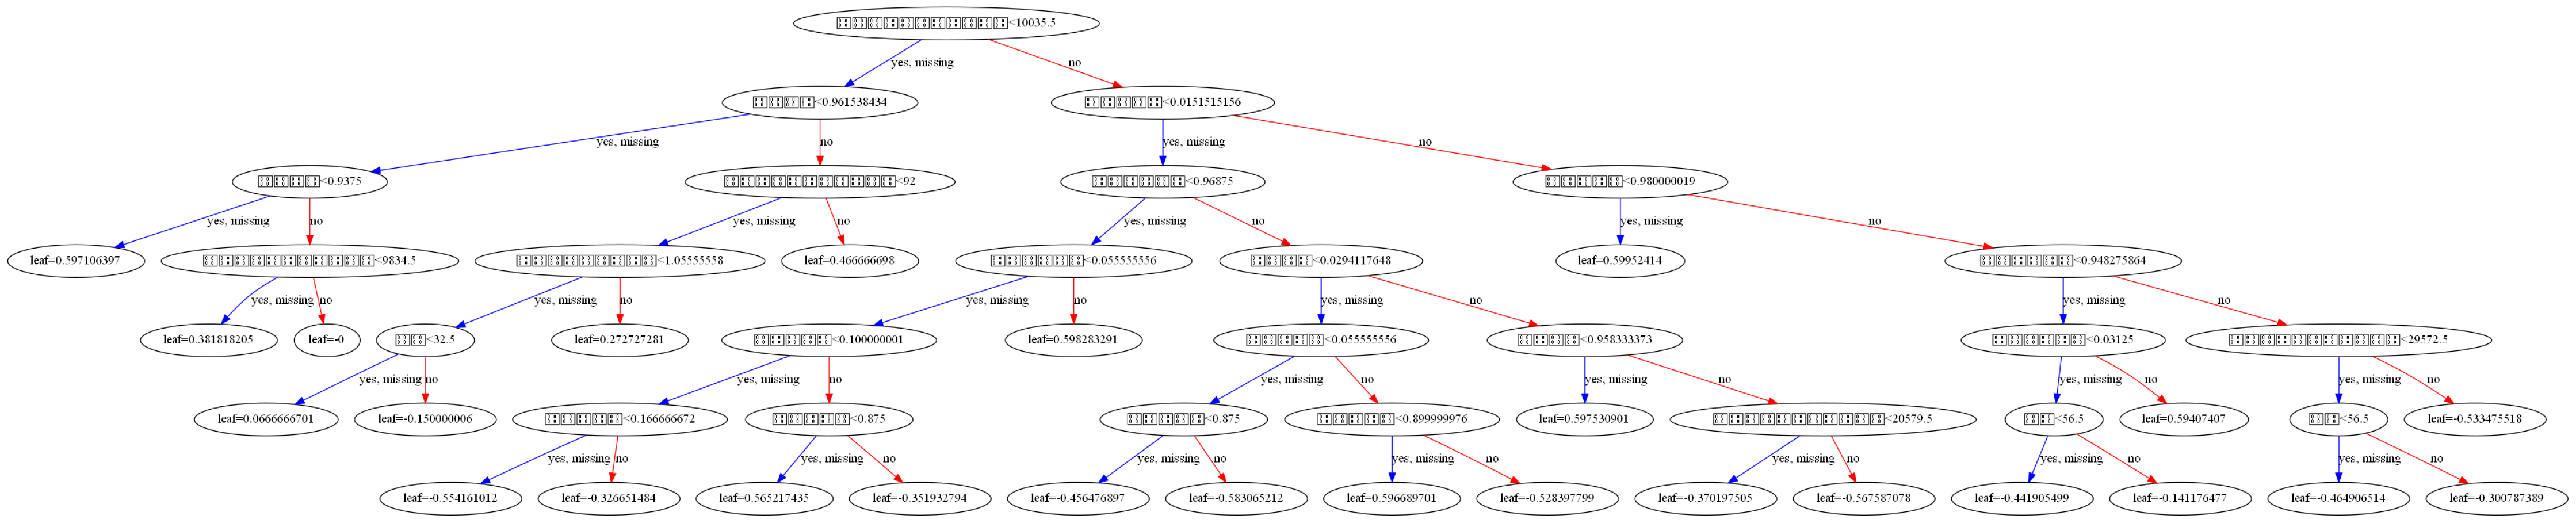

In [39]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 80, 80
plot_tree(xgb)
plt.show()

## Voting Classifier

In [40]:
from sklearn.ensemble import VotingClassifier

In [41]:
# 보팅모델에 넣기 위한 개별 모델
dt = DecisionTreeClassifier(random_state = 0)
xgb = XGBClassifier(random_state = 0)
rf = RandomForestClassifier(random_state = 0)

vo_clf = VotingClassifier(estimators = [ ('XGBoost', xgb),('DecisionTree', dt), ('RandomForest',rf) ], voting='hard')

In [42]:
vo_clf.fit(x_train, y_train)
pred = vo_clf.predict(x_test)

[17:02:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [43]:
print(accuracy_score(y_test, pred))

0.9588087323690594


In [44]:
#개별모델의 학습 예측 평가
classifiers = [dt, rf, xgb]
for classifier in classifiers:
    classifier.fit(x_train, y_train)
    pred=classifier.predict(x_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

DecisionTreeClassifier 정확도: 0.9318
RandomForestClassifier 정확도: 0.9558
[17:03:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier 정확도: 0.9652
